# Chapter 15: Comprehensive Financial Analysis

This chapter dives deep into the heart of financial analysis, where we'll merge and analyze data from a company's income statement, balance sheet, and cash flow statement. This combined view will enable us to calculate crucial performance indicators that shed light on a company's financial health, profitability, efficiency, and risk profile.

**Data Extraction and Preparation**

We'll start by setting up our API connection and retrieving financial statements for Apple (AAPL) from 2021-2023. The Tiingo API provides standardized financial data that we'll organize into pandas DataFrames.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tiingo import TiingoClient

In [2]:
# Configure API connection
os.environ['TIINGO_API_KEY'] = 'YOUR KEY'
client = TiingoClient()

# Define our target company (Apple)
ticker = "AAPL"

# Retrieve financial statements
data = client.get_fundamentals_statements(
    ticker, 
    startDate='2021-01-01', 
    endDate='2023-12-31', 
    asReported=True
)
fundamentals = pd.DataFrame(data)

We need to filter for quarterly data and extract the three main financial statements into separate DataFrames.

In [3]:
# Filter for quarterly reports only
def filter_quarterly_data(data):
    return data[data['quarter'] != 0]

fundamentals = filter_quarterly_data(fundamentals)

# Function to extract specific financial statements
def extract_statement(data, statement_type):
    extracted_data = []
    for _, row in data.iterrows():
        if statement_type in row['statementData']:
            statement = row['statementData'][statement_type]
            for item in statement:
                item['date'] = row['date']
                item['ticker'] = ticker
                item['quarter'] = row['quarter']
                item['year'] = row['year']
                extracted_data.append(item)
    return pd.DataFrame(extracted_data)

# Extract all three statements
income_df = extract_statement(fundamentals, 'incomeStatement')
balance_df = extract_statement(fundamentals, 'balanceSheet')
cash_flow_df = extract_statement(fundamentals, 'cashFlow')

# Pivot to create analysis-ready format
income_pivot = income_df.pivot(index='date', columns='dataCode', values='value').reset_index()
balance_pivot = balance_df.pivot(index='date', columns='dataCode', values='value').reset_index()
cash_flow_pivot = cash_flow_df.pivot(index='date', columns='dataCode', values='value').reset_index()

## 15.1 Data Merging and Preparation

Now we'll combine all three statements into a single DataFrame for comprehensive analysis. We use suffixes to distinguish columns from different statements.

In [4]:
# Merge all financial statements
financials_df = pd.merge(
    income_pivot.reset_index(), 
    balance_pivot.reset_index(), 
    on='date', 
    suffixes=('_income', '_balance')
)
financials_df = pd.merge(
    financials_df, 
    cash_flow_pivot.reset_index(), 
    on='date', 
    suffixes=('', '_cash')
)

# Convert date and set as index
financials_df['date'] = pd.to_datetime(financials_df['date'])
financials_df.set_index('date', inplace=True)

# Display all columns for verification
pd.set_option("display.max_columns", None)
financials_df.head()

dataCode,index_income,consolidatedIncome,costRev,ebit,ebitda,ebt,eps,epsDil,grossProfit,intexp,netIncComStock,netIncDiscOps,netinc,nonControllingInterests,opex,opinc,prefDVDs,revenue,rnd,sga,shareswa,shareswaDil,taxExp,index_balance,accoci,acctPay,acctRec,assetsCurrent,assetsNonCurrent,cashAndEq,debt,debtCurrent,debtNonCurrent,deferredRev,deposits,equity,intangibles,inventory,investments,investmentsCurrent,investmentsNonCurrent,liabilitiesCurrent,liabilitiesNonCurrent,ppeq,retainedEarnings,sharesBasic,taxAssets,taxLiabilities,totalAssets,totalLiabilities,index,businessAcqDisposals,capex,depamor,freeCashFlow,investmentsAcqDisposals,issrepayDebt,issrepayEquity,ncf,ncff,ncfi,ncfo,ncfx,payDiv,sbcomp
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-29,0,2.501000e+10,5.471900e+10,3.083000e+10,3.356700e+10,3.013900e+10,1.54,1.52,4.255900e+10,6.910000e+08,2.501000e+10,0.0,2.501000e+10,0.0,1.258000e+10,2.997900e+10,0.0,9.727800e+10,6.387000e+09,6.193000e+09,1.627880e+10,1.640332e+10,5.129000e+09,0,-6.494000e+09,5.268200e+10,4.540000e+10,1.181800e+11,2.324820e+11,2.809800e+10,1.199810e+11,1.665800e+10,1.033230e+11,7.920000e+09,0.0,6.739900e+10,0.0,5.460000e+09,1.646320e+11,2.341300e+10,1.412190e+11,1.275080e+11,1.557550e+11,3.930400e+10,1.271200e+10,1.618518e+10,0.0,0.0,3.506620e+11,2.832630e+11,0,-167000000.0,-2.514000e+09,2.737000e+09,2.565200e+10,-6.390000e+09,-1.751000e+09,-2.263100e+10,-9.450000e+09,-2.835100e+10,-9.265000e+09,2.816600e+10,0.0,-3.595000e+09,2.252000e+09
2022-07-29,1,1.944200e+10,4.707400e+10,2.378500e+10,2.659000e+10,2.306600e+10,1.20,1.20,3.588500e+10,7.190000e+08,1.944200e+10,0.0,1.944200e+10,0.0,1.280900e+10,2.307600e+10,0.0,8.295900e+10,6.797000e+09,6.012000e+09,1.616294e+10,1.626220e+10,3.624000e+09,1,-9.297000e+09,4.834300e+10,4.224200e+10,1.122920e+11,2.240170e+11,2.750200e+10,1.196910e+11,2.499100e+10,9.470000e+10,7.728000e+09,0.0,5.810700e+10,0.0,5.433000e+09,1.518060e+11,2.072900e+10,1.310770e+11,1.298730e+11,1.483290e+11,4.033500e+10,5.289000e+09,1.607075e+10,0.0,0.0,3.363090e+11,2.782020e+11,1,-2000000.0,-2.102000e+09,2.805000e+09,2.079000e+10,6.953000e+09,9.710000e+08,-2.186500e+10,-3.190000e+08,-2.744500e+10,4.234000e+09,2.289200e+10,0.0,-3.811000e+09,2.243000e+09
2022-10-28,2,2.072100e+10,5.205100e+10,2.548400e+10,2.834900e+10,2.465700e+10,1.29,1.29,3.809500e+10,8.270000e+08,2.072100e+10,0.0,2.072100e+10,0.0,1.320100e+10,2.489400e+10,0.0,9.014600e+10,6.761000e+09,6.440000e+09,1.603038e+10,1.611846e+10,3.936000e+09,2,-1.110900e+10,6.411500e+10,6.093200e+10,1.354050e+11,2.173500e+11,2.364600e+10,1.200690e+11,2.111000e+10,9.895900e+10,7.912000e+09,0.0,5.067200e+10,0.0,4.946000e+09,1.454630e+11,2.465800e+10,1.208050e+11,1.539820e+11,1.481010e+11,4.211700e+10,-3.068000e+09,1.590812e+10,0.0,0.0,3.527550e+11,3.020830e+11,2,-137000000.0,-3.289000e+09,2.865000e+09,2.083800e+10,2.806000e+09,1.657000e+09,-2.442800e+10,-3.884000e+09,-2.679400e+10,-1.217000e+09,2.412700e+10,0.0,-3.703000e+09,2.278000e+09
2023-02-03,3,2.999800e+10,6.682200e+10,3.662600e+10,3.954200e+10,3.562300e+10,1.89,1.88,5.033200e+10,1.003000e+09,2.999800e+10,0.0,2.999800e+10,0.0,1.431600e+10,3.601600e+10,0.0,1.171540e+11,7.709000e+09,6.607000e+09,1.589272e+10,1.595572e+10,5.625000e+09,3,-1.291200e+10,5.791800e+10,5.418000e+10,1.287770e+11,2.179700e+11,2.053500e+10,1.111100e+11,1.148300e+10,9.962700e+10,7.992000e+09,0.0,5.672700e+10,0.0,6.820000e+09,1.449150e+11,3.082000e+10,1.140950e+11,1.372860e+11,1.527340e+11,4.295100e+10,3.240000e+09,1.582195e+10,0.0,0.0,3.467470e+11,2.900200e+11,3,0.0,-3.787000e+09,2.916000e+09,3.021800e+10,2.483000e+09,-9.615000e+09,-1.947500e+10,-3.003000e+09,-3.556300e+10,-1.445000e+09,3.400500e+10,0.0,-3.768000e+09,2.905000e+09
2023-05-05,4,2.416000e+10,5.286000e+10,2.931200e+10,3.221000e+10,2.838200e+10,1.53,1.52,4.197600e+10,9.300000e+08,2.416000e+10,0.0,2.416000e+10,0.0,1.365800e+10,2.831800e+10,0.0,9.483600e+10,7.457000e+09,6.201000e+09,1.578715e+10,1.584705e+10,4.222000e+09,4,-1.1746

## 15.2 Key Performance Indicators (KPIs)

We'll calculate two fundamental profitability metrics:

Return on Assets (ROA): Net Income / Total Assets

Return on Equity (ROE): Net Income / Shareholder Equity

These show how effectively management is using resources to generate profits.

In [5]:
# Calculate profitability ratios
financials_df['return_on_assets'] = financials_df['netinc'] / financials_df['totalAssets']
financials_df['return_on_equity'] = financials_df['netinc'] / financials_df['equity']

# Display results
print(financials_df[['return_on_assets', 'return_on_equity']].dropna())

dataCode    return_on_assets  return_on_equity
date                                          
2022-04-29          0.071322          0.371074
2022-07-29          0.057810          0.334590
2022-10-28          0.058740          0.408924
2023-02-03          0.086513          0.528813
2023-05-05          0.072736          0.388687
2023-08-04          0.059340          0.329844
2023-11-03          0.065108          0.369388


## 15.3 Visualization of KPIs

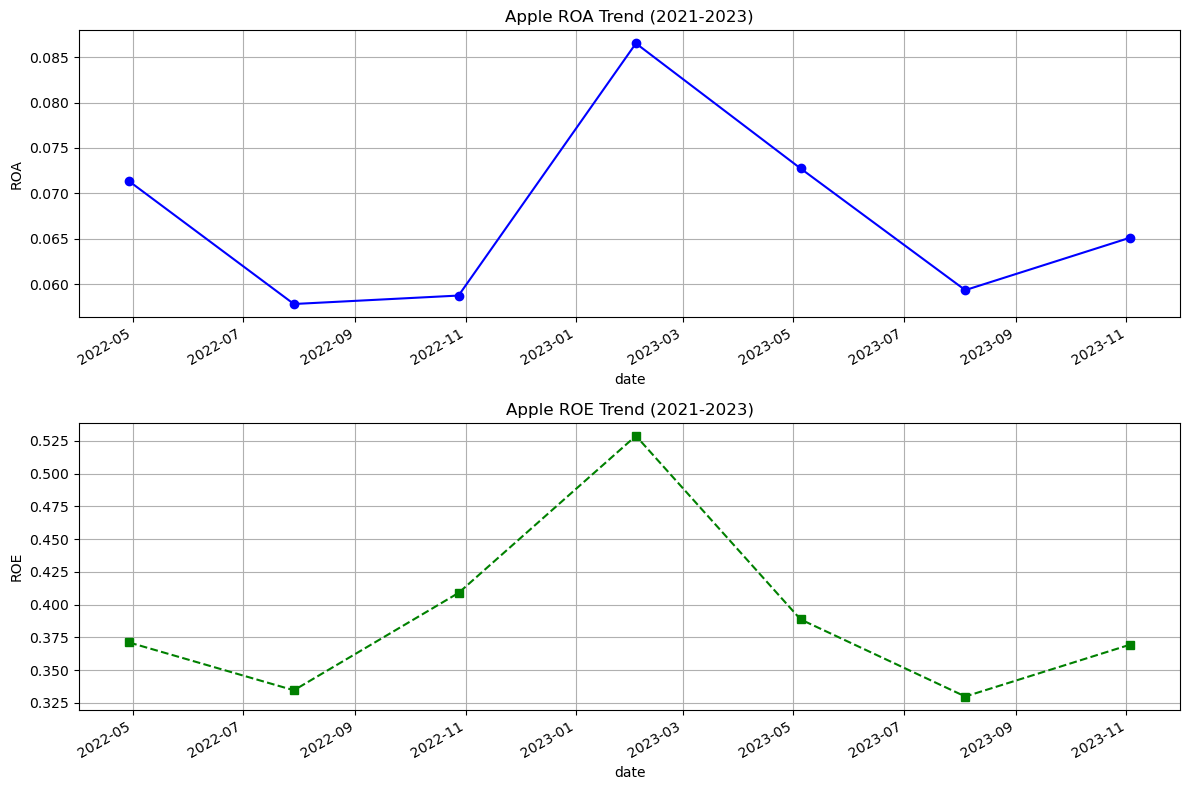

In [6]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ROA Plot
financials_df['return_on_assets'].dropna().plot(
    ax=ax1,
    color='blue',
    marker='o',
    linestyle='-'
)
ax1.set_title('Apple ROA Trend (2021-2023)')
ax1.set_ylabel('ROA')
ax1.grid(True)

# ROE Plot
financials_df['return_on_equity'].dropna().plot(
    ax=ax2,
    color='green',
    marker='s',
    linestyle='--'
)
ax2.set_title('Apple ROE Trend (2021-2023)')
ax2.set_ylabel('ROE')
ax2.grid(True)

plt.tight_layout()
plt.show()

## 15.4 Calculation of Other Common Ratios

In [7]:
# 1. Capitalization Ratios (Financial Structure)
financials_df['debt_to_equity'] = financials_df['debt'] / financials_df['equity']
financials_df['equity_ratio'] = financials_df['equity'] / financials_df['totalAssets']

# 2. Efficiency Ratios (Asset Utilization)
financials_df['asset_turnover'] = financials_df['revenue'] / financials_df['totalAssets']
financials_df['inventory_turnover'] = financials_df['costRev'] / financials_df['inventory']

# 3. Liquidity Ratios (Short-Term Health)
financials_df['current_ratio'] = financials_df['assetsCurrent'] / financials_df['liabilitiesCurrent']
financials_df['quick_ratio'] = (financials_df['assetsCurrent'] - financials_df['inventory']) / financials_df['liabilitiesCurrent']

# 4. Profitability Ratios
financials_df['gross_margin'] = financials_df['grossProfit'] / financials_df['revenue']
financials_df['operating_margin'] = financials_df['opinc'] / financials_df['revenue']

# 5. Cash Flow Ratios
financials_df['operating_cash_flow_ratio'] = financials_df['ncfo'] / financials_df['liabilitiesCurrent']

<Figure size 1000x500 with 0 Axes>

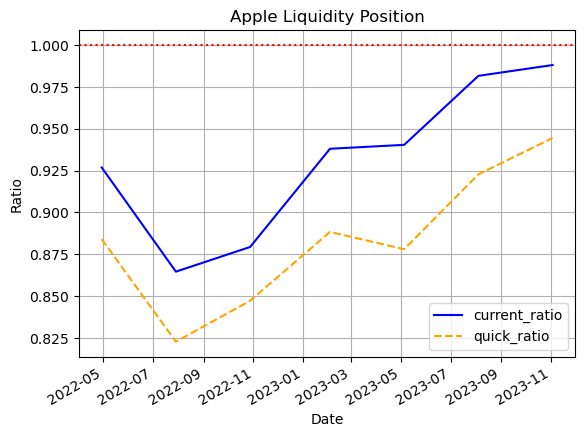

In [8]:
plt.figure(figsize=(10,5))
financials_df[['current_ratio', 'quick_ratio']].plot(
    style=['-', '--'],
    color=['blue', 'orange']
)
plt.title('Apple Liquidity Position')
plt.ylabel('Ratio')
plt.xlabel('Date')
plt.axhline(y=1, color='red', linestyle=':')
plt.grid(True)
plt.legend()
plt.show()

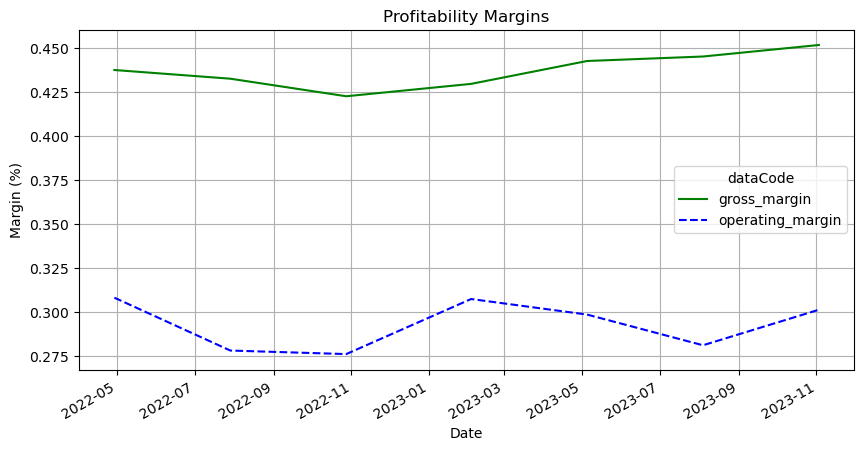

In [9]:
financials_df[['gross_margin', 'operating_margin']].plot(
    figsize=(10,5),
    style=['-g', '--b'],
    title='Profitability Margins'
)
plt.ylabel('Margin (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## 15.5 Summary

This chapter provides a comprehensive framework for analyzing a company's financial health by integrating data from income statements, balance sheets, and cash flow statements. Beginning with data extraction from the Tiingo API, we systematically clean and merge financial statements to create a unified dataset. The analysis then progresses through calculating and interpreting key performance indicators like Return on Assets (ROA) and Return on Equity (ROE), followed by a broader examination of financial ratios across five critical dimensions: capitalization, efficiency, liquidity, profitability, and cash flow. 